<a href="https://colab.research.google.com/github/YLiu95/long-term_forecast_MSc_project/blob/main/compare_non_encoder_decoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## non encoder-decoders

### GRU, single GRU layer RMSprop optimisation

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # lable timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 100, 1) float64 
 testing data: (132, 100, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform
# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
model.add(GRU(units=512))
model.add(Dense(n_steps_out, kernel_initializer=init))

# complie the model
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 43.0549 - rmse: 6.2802
Epoch 1: val_rmse improved from inf to 2.12723, saving model to 23_checkpoint.keras
7/7 [==============================] - 2s 97ms/step - loss: 38.0786 - rmse: 5.7809 - val_loss: 4.6349 - val_rmse: 2.1272 - lr: 0.0010
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 2.1883 - rmse: 1.3395
Epoch 2: val_rmse improved from 2.12723 to 0.22221, saving model to 23_checkpoint.keras
7/7 [==============================] - 0s 34ms/step - loss: 1.8989 - rmse: 1.2007 - val_loss: 0.0629 - val_rmse: 0.2222 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0700 - rmse: 0.2399
Epoch 3: val_rmse improved from 0.22221 to 0.17091, saving model to 23_checkpoint.keras
7/7 [==============================] - 0s 34ms/step - loss: 0.0700 - rmse: 0.2399 - val_loss: 0.0303 - val_rmse: 0.1709 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.035

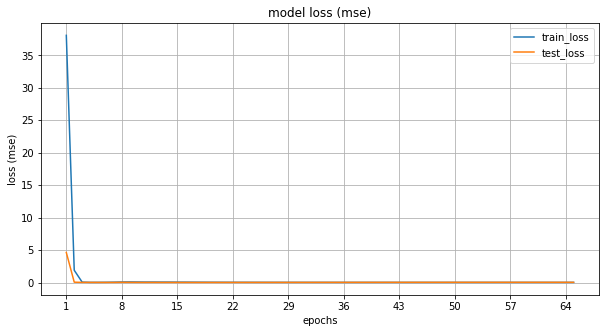

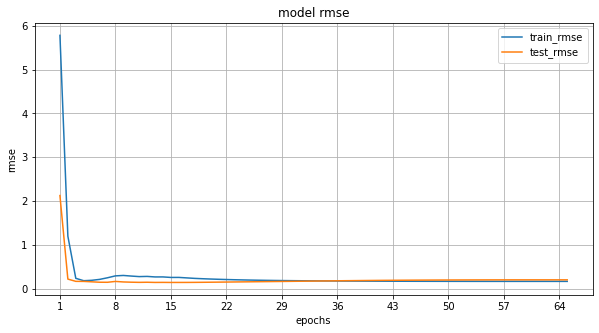

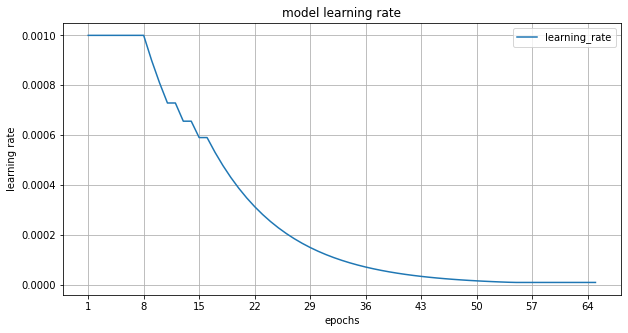

CPU times: user 14.5 s, sys: 847 ms, total: 15.4 s
Wall time: 22.8 s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    model.evaluate(X_train, y_train)
    model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.0227 - rmse: 0.1458
CPU times: user 244 ms, sys: 20.5 ms, total: 264 ms
Wall time: 433 ms


In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.0227 - rmse: 0.1458
CPU times: user 230 ms, sys: 24.2 ms, total: 254 ms
Wall time: 318 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.05752391763827146 
 test mse:  0.022659731392709336
 train rmse: 0.2395905609090851 
 test rmse:  0.15051444743003192
CPU times: user 799 ms, sys: 16.3 ms, total: 815 ms
Wall time: 955 ms


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

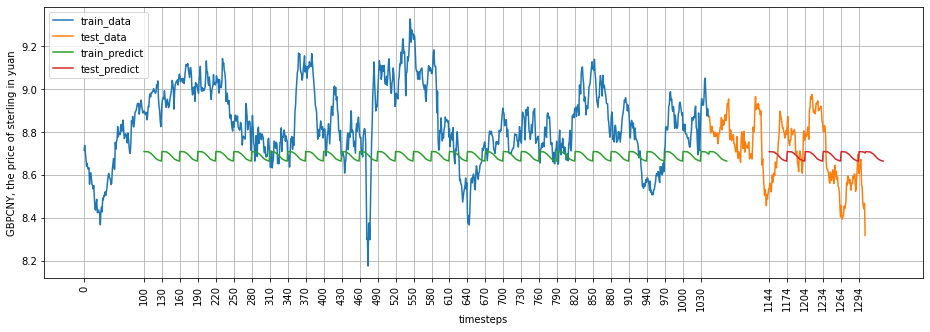

metrics calucalted with `model.evaluate()`: 
 train mse: 0.05752391368150711 
 test mse:  0.02265973761677742 
 train rmse: 0.21491873264312744 
 test rmse:  0.14584466814994812 
 metrics calucalted manually: 
 train mse: 0.05752391763827146 
 test mse:  0.022659731392709336 
 train rmse: 0.2395905609090851 
 test rmse:  0.15051444743003192 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.689421 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.689277 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.016529776 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.016499793


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

#### the end of the section

### bidirectional GRU, RMSprop optimisation

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 100, 1) float64 
 testing data: (132, 100, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
forward_layer = GRU(256, activation='relu')
backward_layer = GRU(256, activation='relu', go_backwards=True)
model.add(Bidirectional(forward_layer, 
                        backward_layer=backward_layer,
                        input_shape=(n_steps_in, n_features)))
model.add(Dense(256, activation='relu', kernel_initializer=init))
model.add(Dense(n_steps_out, kernel_initializer=init))

# complie the model
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 512)              397824    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 30)                7710      
                                                                 
Total params: 536,862
Trainable params: 536,862
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 53.6943 - rmse: 7.0584
Epoch 1: val_rmse improved from inf to 3.56541, saving model to 23_checkpoint.keras
7/7 [==============================] - 8s 450ms/step - loss: 53.6943 - rmse: 7.0584 - val_loss: 12.8302 - val_rmse: 3.5654 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 3.4572 - rmse: 1.5790
Epoch 2: val_rmse improved from 3.56541 to 0.76714, saving model to 23_checkpoint.keras
7/7 [==============================] - 3s 363ms/step - loss: 3.4572 - rmse: 1.5790 - val_loss: 0.5814 - val_rmse: 0.7671 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.4541 - rmse: 1.1013
Epoch 3: val_rmse did not improve from 0.76714

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
7/7 [==============================] - 3s 371ms/step - loss: 1.4541 - rmse: 1.1013 - val_loss: 3.1000 - val_rmse: 1.7441 - lr: 0.0010
Epoch 4/100
7/7 [===============

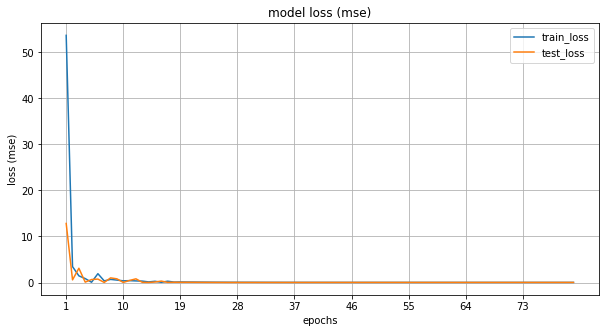

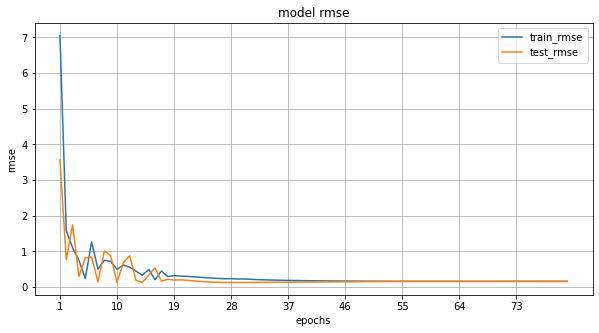

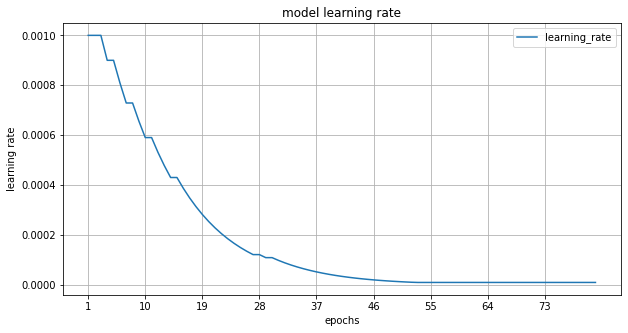

CPU times: user 5min 26s, sys: 42.9 s, total: 6min 9s
Wall time: 3min 44s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 33ms/step - loss: 0.0186 - rmse: 0.1278
CPU times: user 1.14 s, sys: 19.5 ms, total: 1.16 s
Wall time: 1.65 s


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.03976937067438754 
 test mse:  0.01855311665546423
 train rmse: 0.19938069237902686 
 test rmse:  0.1356421279941473
CPU times: user 1.4 s, sys: 32.8 ms, total: 1.43 s
Wall time: 1.95 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

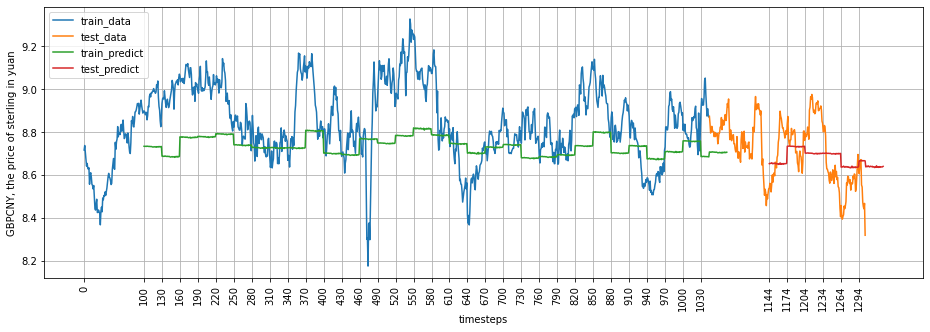

metrics calucalted with `model.evaluate()`: 
 train mse: 0.03976937010884285 
 test mse:  0.0185531172901392 
 train rmse: 0.1800970435142517 
 test rmse:  0.12780709564685822 
 metrics calucalted manually: 
 train mse: 0.03976937067438754 
 test mse:  0.01855311665546423 
 train rmse: 0.19938069237902686 
 test rmse:  0.1356421279941473 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.734475 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.683129 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.03647247 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.03962802


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

#### the end of the section

### CNN-GRU, triple CNN layers - triple GRU layers, RMSprop optimisation

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 5, 20, 1) float64 
 testing data: (132, 5, 20, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=7, activation='relu'), 
                          input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(Conv1D(filters=512, kernel_size=5, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=1024, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(2048, return_sequences=True, activation='relu'))
model.add(GRU(1024, return_sequences=True, activation='relu'))
model.add(GRU(512, activation='relu'))
model.add(Dense(256, activation='relu', kernel_initializer=init))
model.add(Dense(n_steps_out, kernel_initializer=init))

# complie the model
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_62 (TimeDi  (None, None, 14, 256)    2048      
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, None, 10, 512)    655872    
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, None, 8, 1024)    1573888   
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, None, 4, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, None, 4096)     

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 868.6242 - rmse: 21.3750
Epoch 1: val_rmse improved from inf to 10.63529, saving model to 23_checkpoint.keras
7/7 [==============================] - 6s 325ms/step - loss: 868.6242 - rmse: 21.3750 - val_loss: 112.5748 - val_rmse: 10.6353 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 197.4514 - rmse: 11.7214
Epoch 2: val_rmse improved from 10.63529 to 8.55965, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 177ms/step - loss: 197.4514 - rmse: 11.7214 - val_loss: 73.6826 - val_rmse: 8.5597 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 38.1037 - rmse: 5.4514
Epoch 3: val_rmse improved from 8.55965 to 6.61403, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 180ms/step - loss: 38.1037 - rmse: 5.4514 - val_loss: 44.0752 - val_rmse: 6.6140 - lr: 0.0010
Epoch 4/100
7/7 [==============================] -

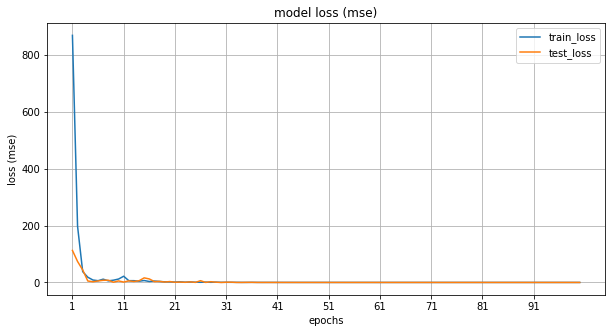

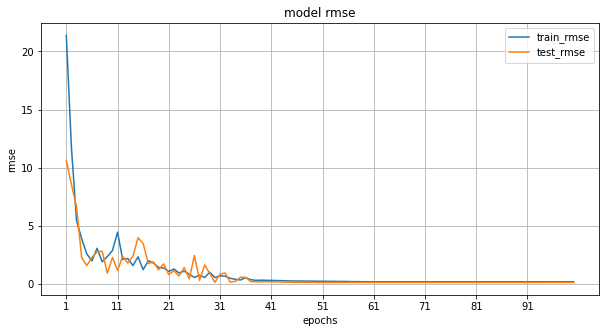

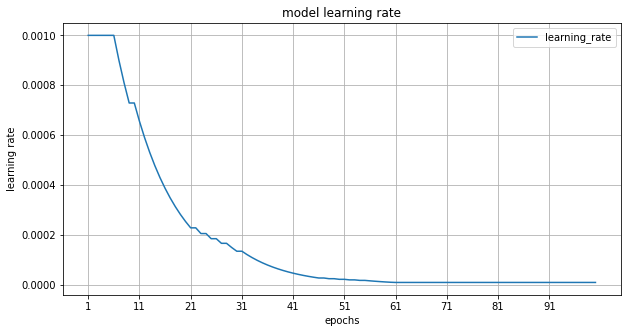

CPU times: user 1min 31s, sys: 6.91 s, total: 1min 38s
Wall time: 1min 38s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 8ms/step - loss: 0.0242 - rmse: 0.1483
CPU times: user 323 ms, sys: 16.2 ms, total: 339 ms
Wall time: 428 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
train_predict = train_predict.reshape((train_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
test_predict = test_predict.reshape((test_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('all training data for prediction:', train_predict.shape, train_predict.dtype, '\n',
      'all testing data for prediction:', test_predict.shape, test_predict.dtype)

all training data for prediction: (944, 5, 20, 1) float64 
 all testing data for prediction: (161, 5, 20, 1) float64


In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.048990054022166905 
 test mse:  0.024246903744922787
 train rmse: 0.22130616839441483 
 test rmse:  0.15570887889836713
CPU times: user 756 ms, sys: 10.3 ms, total: 766 ms
Wall time: 818 ms


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.727678

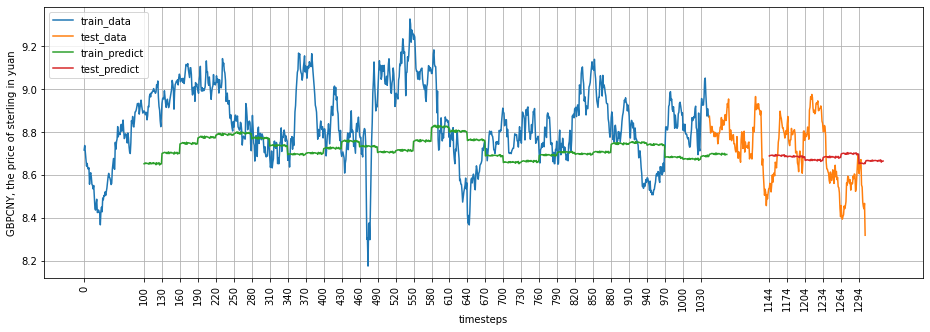

metrics calucalted with `model.evaluate()`: 
 train mse: 0.048990052193403244 
 test mse:  0.024246906861662865 
 train rmse: 0.19983042776584625 
 test rmse:  0.14825963973999023 
 metrics calucalted manually: 
 train mse: 0.048990054022166905 
 test mse:  0.024246903744922787 
 train rmse: 0.22130616839441483 
 test rmse:  0.15570887889836713 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.727678 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.681865 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.04335591 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.0125021525


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

#### the end of the section

### convLSTM, triple convLSTM layer, RMSprop optimisation

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 5, 20, 1) float64 
 testing data: (132, 5, 20, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
model.add(ConvLSTM1D(filters=256, kernel_size=10, activation='relu',
                     return_sequences=True,
                     input_shape=(n_seq, n_steps, n_features)))
model.add(ConvLSTM1D(filters=512, kernel_size=5, activation='relu',
                     return_sequences=True))
model.add(ConvLSTM1D(filters=1024, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_initializer=init))
model.add(Dense(1024, activation='relu', kernel_initializer=init))
model.add(Dense(n_steps_out, kernel_initializer=init))

# complie the model
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_10 (ConvLSTM1D)  (None, 5, 11, 256)       2632704   
                                                                 
 conv_lstm1d_11 (ConvLSTM1D)  (None, 5, 7, 512)        7866368   
                                                                 
 conv_lstm1d_12 (ConvLSTM1D)  (None, 5, 1024)          18878464  
                                                                 
 flatten_4 (Flatten)         (None, 5120)              0         
                                                                 
 dense_13 (Dense)            (None, 2048)              10487808  
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 30)               

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 162058.3906 - rmse: 216.3307
Epoch 1: val_rmse improved from inf to 8.48310, saving model to 23_checkpoint.keras
7/7 [==============================] - 19s 611ms/step - loss: 162058.3906 - rmse: 216.3307 - val_loss: 72.3754 - val_rmse: 8.4831 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 65.6411 - rmse: 7.2690
Epoch 2: val_rmse improved from 8.48310 to 5.93128, saving model to 23_checkpoint.keras
7/7 [==============================] - 3s 404ms/step - loss: 65.6411 - rmse: 7.2690 - val_loss: 35.4875 - val_rmse: 5.9313 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 24.8120 - rmse: 4.8666
Epoch 3: val_rmse improved from 5.93128 to 2.05445, saving model to 23_checkpoint.keras
7/7 [==============================] - 3s 395ms/step - loss: 24.8120 - rmse: 4.8666 - val_loss: 4.3390 - val_rmse: 2.0545 - lr: 0.0010
Epoch 4/100
7/7 [==============================] -

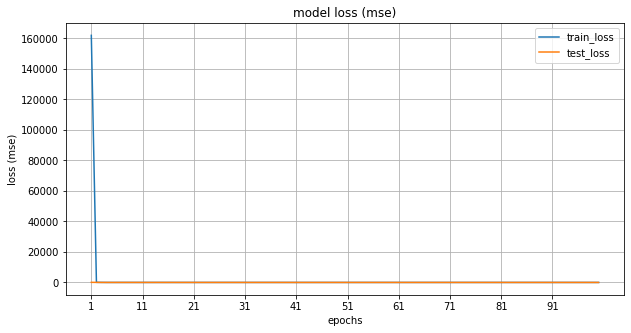

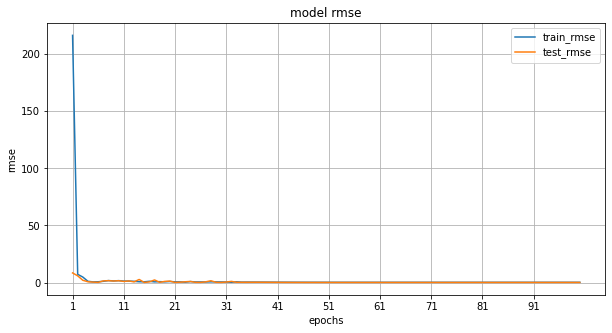

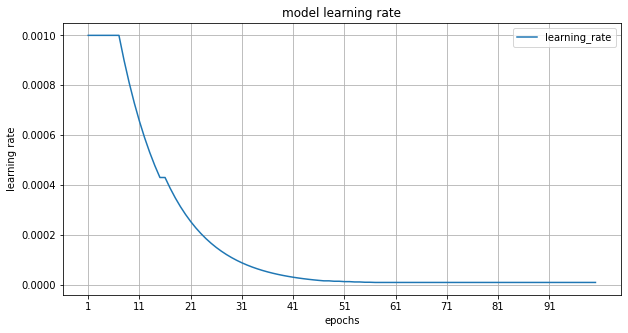

CPU times: user 3min 53s, sys: 53.8 s, total: 4min 46s
Wall time: 4min 31s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 50ms/step - loss: 0.0250 - rmse: 0.1502
CPU times: user 853 ms, sys: 49.3 ms, total: 903 ms
Wall time: 1.92 s


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
train_predict = train_predict.reshape((train_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
test_predict = test_predict.reshape((test_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('all training data for prediction:', train_predict.shape, train_predict.dtype, '\n',
      'all testing data for prediction:', test_predict.shape, test_predict.dtype)

all training data for prediction: (944, 5, 20, 1) float64 
 all testing data for prediction: (161, 5, 20, 1) float64


In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.06495088208357877 
 test mse:  0.02500414748230672
 train rmse: 0.2548423741563481 
 test rmse:  0.15792475463126315
CPU times: user 2.93 s, sys: 36.9 ms, total: 2.96 s
Wall time: 4.41 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.745656

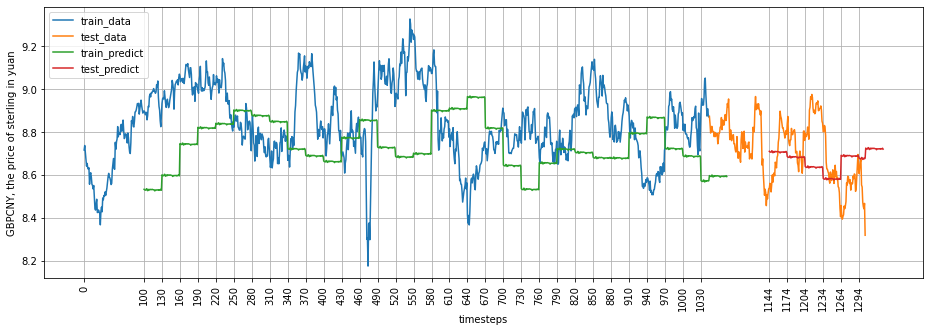

metrics calucalted with `model.evaluate()`: 
 train mse: 0.06495089828968048 
 test mse:  0.025004159659147263 
 train rmse: 0.2350589781999588 
 test rmse:  0.15016736090183258 
 metrics calucalted manually: 
 train mse: 0.06495088208357877 
 test mse:  0.02500414748230672 
 train rmse: 0.2548423741563481 
 test rmse:  0.15792475463126315 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.745656 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.667964 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.10889743 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.03748381


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

#### the end of the section

### bidirectional convLSTM, single bidirectional convLSTM layer, RMSprop optimisation

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 5, 20, 1) float64 
 testing data: (132, 5, 20, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM1D
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
forward_layer = ConvLSTM1D(filters=256, kernel_size=10)
backward_layer = ConvLSTM1D(filters=256, kernel_size=10, go_backwards=True)
model.add(Bidirectional(forward_layer, 
                        backward_layer=backward_layer,
                        input_shape=(n_seq, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_initializer=init))
model.add(Dense(1024, activation='relu', kernel_initializer=init))
model.add(Dense(n_steps_out, kernel_initializer=init))

# complie the model
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 11, 512)          5265408   
 nal)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 5632)              0         
                                                                 
 dense_23 (Dense)            (None, 2048)              11536384  
                                                                 
 dense_24 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_25 (Dense)            (None, 30)                30750     
                                                                 
Total params: 18,930,718
Trainable params: 18,930,718
Non-trainable params: 0
_________________________________________

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 151.6531 - rmse: 10.3030
Epoch 1: val_rmse improved from inf to 9.13471, saving model to 23_checkpoint.keras
7/7 [==============================] - 7s 294ms/step - loss: 151.6531 - rmse: 10.3030 - val_loss: 83.0417 - val_rmse: 9.1347 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 34.2711 - rmse: 5.0693
Epoch 2: val_rmse improved from 9.13471 to 1.47337, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 152ms/step - loss: 34.2711 - rmse: 5.0693 - val_loss: 2.1104 - val_rmse: 1.4734 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 3.5315 - rmse: 1.7972
Epoch 3: val_rmse did not improve from 1.47337

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
7/7 [==============================] - 1s 128ms/step - loss: 3.5315 - rmse: 1.7972 - val_loss: 3.7327 - val_rmse: 1.9038 - lr: 0.0010
Epoch 4/100
7/7 [=========

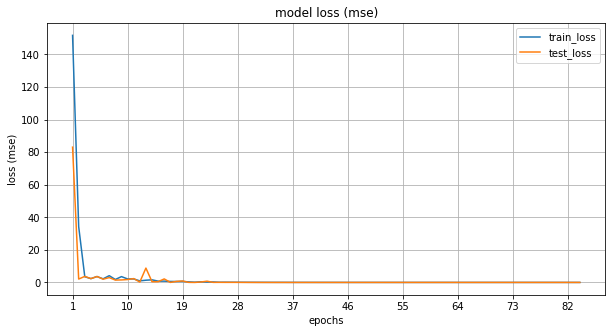

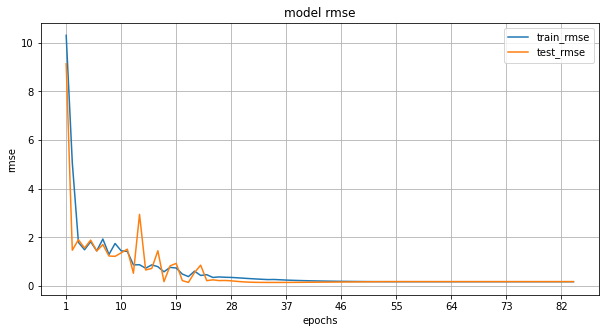

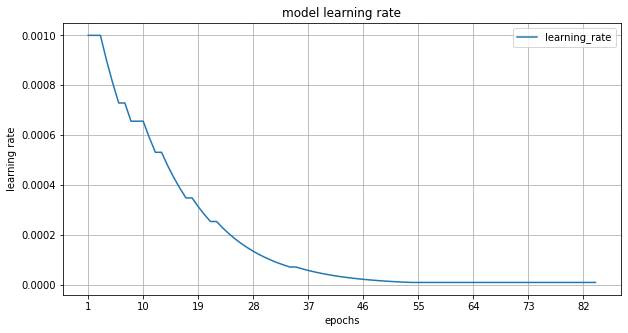

CPU times: user 1min 49s, sys: 7.35 s, total: 1min 56s
Wall time: 2min 27s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.0239 - rmse: 0.1483
CPU times: user 499 ms, sys: 25.9 ms, total: 525 ms
Wall time: 636 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
train_predict = train_predict.reshape((train_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
test_predict = test_predict.reshape((test_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('all training data for prediction:', train_predict.shape, train_predict.dtype, '\n',
      'all testing data for prediction:', test_predict.shape, test_predict.dtype)

all training data for prediction: (944, 5, 20, 1) float64 
 all testing data for prediction: (161, 5, 20, 1) float64


In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.06305424737649105 
 test mse:  0.02392753740501844
 train rmse: 0.2510999790440946 
 test rmse:  0.15467632760866384
CPU times: user 1.02 s, sys: 19.4 ms, total: 1.04 s
Wall time: 1.02 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.67179

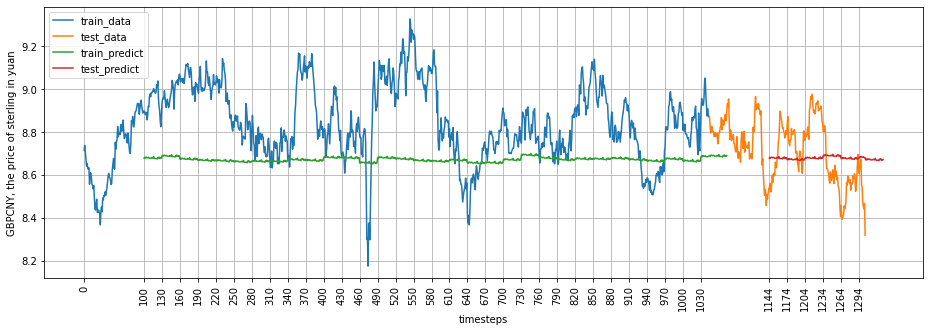

metrics calucalted with `model.evaluate()`: 
 train mse: 0.06305424869060516 
 test mse:  0.023927541449666023 
 train rmse: 0.22582100331783295 
 test rmse:  0.1483396589756012 
 metrics calucalted manually: 
 train mse: 0.06305424737649105 
 test mse:  0.02392753740501844 
 train rmse: 0.2510999790440946 
 test rmse:  0.15467632760866384 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.67179 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.678711 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.009310334 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.00669135


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

#### the end of the section